Logistic regression

## What IS NOT a logistic regression?

Logistic regression is not:

- a fit of a sigmoid curve to a set of points $(x_1, y_1), ..., (x_n, y_n)$
- a classification method - although it is often used for this purpose

## What IS a logistic regression?

Logistic regression is a regression model that returns a probability of a binary outcome (0 or 1), assuming that log of the odds-ratio is a linear combination of one or more inputs. Odds ratio is ratio between probability of outcome happening (1) and the probability of the outcome not happening (0).

The goal behind logistic regression is to model cases when the input(s) are affecting the outcome in a probabilistic way. This outcome probability is assumed to be an S-shaped curve that can be expressed with the following mathematical equation:

$$
p(x) = \frac{1}{1 + e^{-k(x - x_0)}}
$$ 


## Logistic curve

Let's plot the curve first, for example with $x_0 = 2.5$ and $k = 3$:

In [13]:
import numpy as np
import pandas as pd
import plotnine as p9

from scipy.stats import uniform, bernoulli
np.random.seed(1)

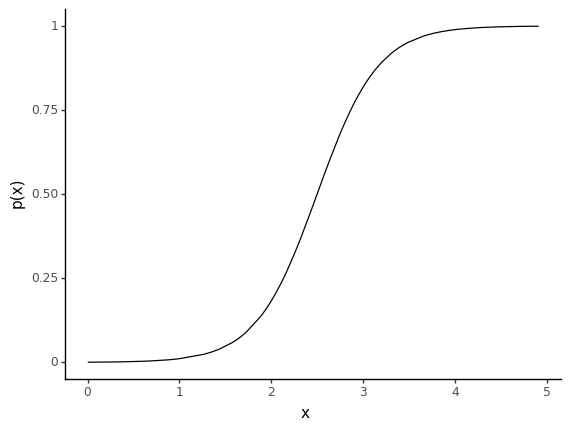

<ggplot: (8756254375129)>

In [31]:
def logistic(x, k, x0):
    return 1 / (1 + np.exp(-k*(x - x0)))

def create_logistic_curve_data(k, x0, n_points):
    df = pd.DataFrame({
        'x': np.sort(uniform.rvs(loc=0, scale=5, size=n_points))
    })
    df['p_x'] = logistic(df['x'], k, x0)
    return df

def plot_logistic_curve(k, x0, n_points=100):
    df = create_logistic_curve_data(k, x0, n_points)
    return (
        p9.ggplot(df, p9.aes('x', 'p_x'))
	    + p9.geom_line()
        + p9.scale_y_continuous(name='p(x)')
        + p9.theme_classic()
    )

plot_logistic_curve(3, 2.5)

The meaning of these two parameters is:
- $x_0$ is the value of a predictor x for which the probability is 0.5 (mid-point): $p(x = x_0) = 0.5$, so tells us about the location of the mid-point.
- $k$ is related to the slope of the probability at that point: $(dp/dx)_{x = x_0} = k/4$, so tells us about the steepness of the curve at that mid-point. The larger the $k$, the steeper the curve.

## How do we fit the data?

As mentioned earlier, the fitting process in logistic regression is different than in linear regression. In linear regression, ordinary least square approach takes vertical differences between the predicted line and data points (residuals), squares them, then adds them up.

What if we tried the same here anyway?

Let's add some points to the previous plot to see if this would work or make sense here:

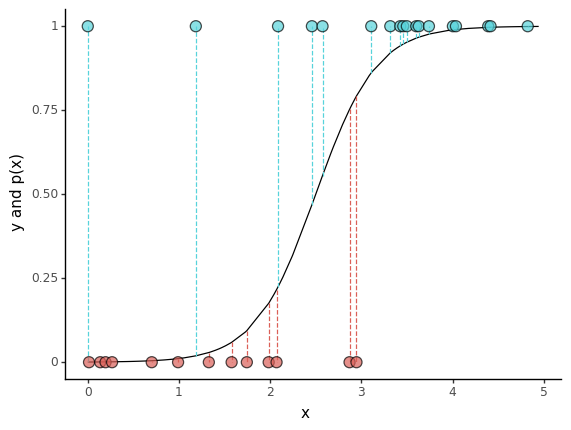

<ggplot: (8756255197308)>

In [39]:
from scipy.stats import uniform, bernoulli

np.random.seed(1)

def add_sample_data_to_random_rows(df, n_data_points):
    data_rows = df.sample(n_data_points)
    df.loc[data_rows.index, 'y'] = bernoulli.rvs(
        df.loc[data_rows.index, 'p_x']
    )
    # df.loc[data_rows.index, ].loc[[0, 1]] = 1
    return df

def plot_logistic_curve_and_sample_data(k, x0, n_data_points):
    n_curve_points = max(n_data_points, 100)
    df = create_logistic_curve_data(k, x0, n_curve_points)
    df = add_sample_data_to_random_rows(df, n_data_points)
    df.loc[0, 'y'] = 1
    return (
        p9.ggplot(df, p9.aes('x'))
	    + p9.geom_line(
            mapping=p9.aes(y='p_x')
        )
        + p9.geom_linerange(
            data=df[df['y'].notna()],
            mapping=p9.aes(ymin='p_x', ymax='y', color='factor(y)'),
            linetype='dashed'
        )
        + p9.geom_point(
            data=df[df['y'].notna()],
            mapping=p9.aes(y='y', fill='factor(y)'),
            size=4,
            alpha=0.7,
            shape='o'
        )
        + p9.scale_y_continuous(name='y and p(x)')
        + p9.theme_classic()
        + p9.theme(legend_position='none')
    )

plot_logistic_curve_and_sample_data(3, 2.5, n_data_points=30)

Here, we colored the points at $y = 0$ in red and points at $y = 1$ in teal.

One of the immediate problems is that the residual of each point can be at most 1. Because of this, the top 3 points (for y = 1) have almost the same residuals. However, it would make more sense to assign a much larger cost to the first teal point that appears at $x=0$ than to the second one at $x=1.2$.

Then, what is the approach employed by logistic regression?



In [4]:


def calculate_px(x0, k):
	x = np.linspace(0, 5, 100)
	px_df = pd.DataFrame({
		'x': x,
		'y': logistic(x, k, x0)
	})
	return px_df

def create_test_data(n, x0, k):
	df = pd.DataFrame({
		'x': uniform.rvs(loc=0, scale=5, size=n)
	})
	df['p_x'] = logistic(df['x'], k, x0)
	df['y'] = bernoulli.rvs(df['p_x'])
	return df

df = create_test_data(n=20, x0=2.5, k=3)
df

,x,p_x,y
0,2.085110,0.223624,1
1,3.601622,0.964595,0
2,0.000572,0.000554,0
3,1.511663,0.049032,0
4,0.733779,0.004973,0
5,0.461693,0.002205,0
6,0.931301,0.008959,0
7,1.727804,0.089758,0
8,1.983837,0.175305,0
9,2.694084,0.641585,0


In [5]:

def calculate_px(k, x0):
	x = np.linspace(0, 5, 100)
	px_df = pd.DataFrame({
		'x': x,
		'y': logistic(x, k, x0)
	})
	return px_df

px_df = calculate_px(2.5, 3)

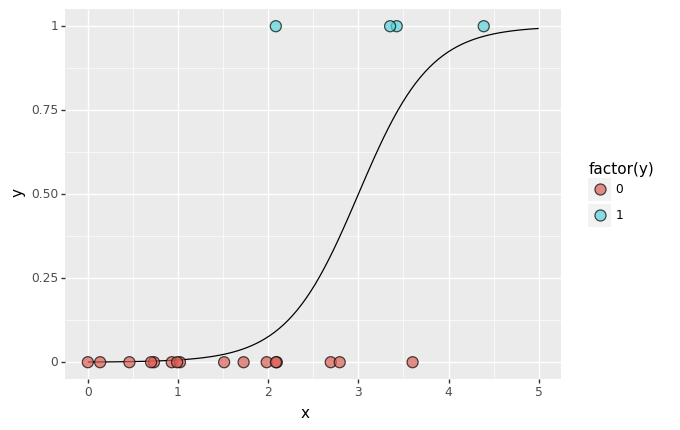

<ggplot: (8751951564951)>

In [6]:
def plot_data_and_px(df, px_df):
	return (
		p9.ggplot(df, p9.aes('x', 'y'))
		+ p9.geom_line(data=px_df)
		+ p9.geom_point(size=4, shape='o', alpha=0.7, mapping=p9.aes(fill='factor(y)'))
	)

plot_data_and_px(df, px_df)

Define probability of y = 1:

$$
p(x) = \frac{1}{1 + e^{\beta_1 x + \beta_0}}
$$ 

We can fit the points to log-probabilities. For y = 1 we are fitting the points to:

$$
-\log p(x) = -\log\frac{1}{1 + e^{\beta_1 x + \beta_0}} = \log\left( 1 + e^{\beta_1 x + \beta_0}\right)
$$

And for y = 0, we are fitting the points to:

$$
\begin{align}
 -\log\left[1 - p(x)\right] & = -\log\left(1 - \frac{1}{1 + e^{\beta_1 x + \beta_0}}\right) \\
 & = -\log\left(
    \frac{1 + e^{\beta_1 x + \beta_0}}{1 + e^{\beta_1 x + \beta_0}} - 
    \frac{1}{1 + e^{\beta_1 x + \beta_0}}
    \right) \\
 & = -\log\frac{e^{\beta_1 x + \beta_0}}{1 + e^{\beta_1 x + \beta_0}} \\
 & = -\log\frac{1}{1 + e^{-(\beta_1 x + \beta_0)}} \\
 & = \log\left(1 + e^{-(\beta_1 x + \beta_0)}\right)
\end{align}
$$

In [7]:
def log_loss(p_x, y):
    return -y * np.log(p_x) - (1 - y) * np.log(1 - p_x)

Total log-loss:  5.977928116822993


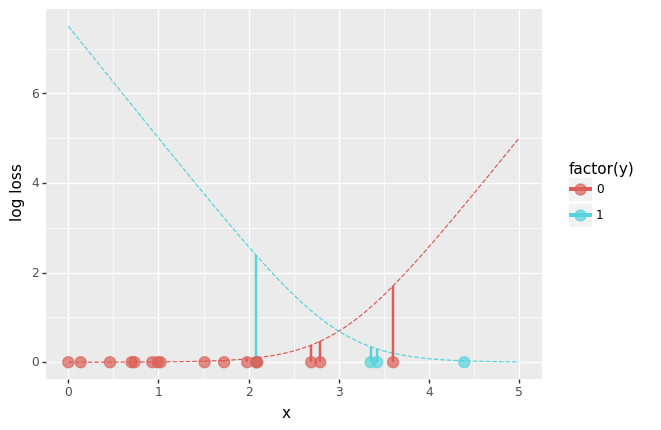

<ggplot: (8751949309212)>

In [8]:
# steepness = 3
# x_offset = 2.5

# beta1 = 1
# beta0 = 2.5

def plot_logistic_fit(df, k, x0):
	x = np.linspace(0, 5, 100)
	px = logistic(x, k, x0)

	df['px'] = logistic(df['x'], k, x0)
	df['log_loss'] = log_loss(df['px'], df['y'])

	print('Total log-loss: ', np.sum(df['log_loss']))

	log_loss_df = pd.DataFrame({
		'x': np.concatenate((x, x)),
		'y': np.concatenate((
			[0] * len(x),
			[1] * len(x)
		)),
		'log_loss': np.concatenate((
			log_loss(px, y=0),
			log_loss(px, y=1)
		)),
		# 'log_loss_0': log_loss(px, y=0),
		# 'log_loss_1': log_loss(px, y=1),
	})

	return (
		p9.ggplot(df, p9.aes('x', 0, color='factor(y)', fill='factor(y)'))
		+ p9.geom_line(data=log_loss_df, mapping=p9.aes('x', 'log_loss'), linetype='dashed')
		+ p9.geom_linerange(mapping=p9.aes(ymin=0, ymax='log_loss'), size=1)
		+ p9.geom_point(size=4, shape='o', alpha=0.7)
		+ p9.scale_y_continuous(name='log loss')
		# + ylim(0, 5)
	)

plot_logistic_fit(df, 2.5, 3)